In [57]:
import pandas as pd
import numpy as np

In [58]:
animes = pd.read_csv("data/animes.csv", index_col=0)
profiles = pd.read_csv("data/profiles.csv", index_col=0)
#review = pd.read_csv("data/review.csv")

In [59]:
animes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19311 entries, 28891 to 87
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       19311 non-null  object 
 1   synopsis    18336 non-null  object 
 2   genre       19311 non-null  object 
 3   aired       19311 non-null  object 
 4   episodes    18605 non-null  float64
 5   members     19311 non-null  int64  
 6   popularity  19311 non-null  int64  
 7   ranked      16099 non-null  float64
 8   score       18732 non-null  float64
 9   img_url     19131 non-null  object 
 10  link        19311 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 1.8+ MB


In [60]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81727 entries, DesolatePsyche to nyja-chan
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gender           53856 non-null  object
 1   birthday         46807 non-null  object
 2   favorites_anime  81727 non-null  object
 3   link             81727 non-null  object
dtypes: object(4)
memory usage: 3.1+ MB


# Perfis dos usuários

### Resgatando datas de aniversário

O objetivo principal nesta tarefa de *parsing* é preservar a informação idade do usuário, para isto, os *strings* com a informação do ano de nascimento (ou algo que possa ser usado como tal) precisam ser mantidos, todos os outros podem ser descartados.

In [61]:
def parse_birth_dates(string):
    
    if string==np.nan:
        return np.nan

    # typical cases, people born before 2000
    formats = (
        # complete information:
        "%b %d, %Y", 
        # day missing:
        "%b %Y", "%m, %Y", 
        # month missing:
        "%d, %Y",
        # day and month missing:
        "%Y", "%y")

    for form in formats:
        try:
            return pd.to_datetime(string, format=form)
        except:
            continue

    # special cases, people born in the 2000s and after
    curr_year = str(pd.to_datetime("today").year)
    max_valid = int(f"{curr_year}"[2:])

    # parsing "%y", month and day missing (probably "%d" being treated as the former)
    # leaving uncommented due to low impact on the data
    if len(string)==1:
        try:
            if int(string) < max_valid:
                string = f"20{int(string):02}"
                return pd.to_datetime(string, format="%Y")
        except:
            pass
    # parsing "%b %y", day missing (probably "%b %d" being treated as the former)
    # leaving commented
    # else:
    #     try:
    #         
    #         str_elements = string.split(" ")
    #         if int(str_elements[1]) < max_valid:
    #             string = f"{str_elements[0]} 20{int(str_elements[1]):02}"
    #             return pd.to_datetime(string, format="%b %Y")
    #     except:
    #         pass
            
    return np.nan

In [62]:
# Know which dates were not parsed    
dict_transform = {x: parse_birth_dates(x) for x in profiles["birthday"].unique()}
parsed = profiles["birthday"].map(dict_transform)
not_parsed_names = parsed.loc[np.isnan(parsed)].index
not_parsed_values = profiles["birthday"].loc[not_parsed_names]
nan_amount = not_parsed_values.isnull().sum()

print(f"Not parsed: \n{list(not_parsed_values.unique())}")
print(
    f"\nAmount of not parsed: {len(not_parsed_values) - nan_amount}",
    f"Amount of nan: {nan_amount}",
    sep="\n")

Not parsed: 
[nan, 'Sep 5', 'Oct 6', 'Aug 23', 'Jun 2', 'Jul 17', 'Sep 25', 'Aug 31', 'Mar 19', 'Sep 26', 'Jun 30', 'Apr 10', 'Jun 22', 'Jul 11', 'Apr 12', 'May 14', 'Sep 28', 'Jan 8', 'Jun 15', 'Oct 11', 'Dec 27', 'Jun 1', 'Aug 21', 'Nov 12', 'Oct 20', 'Nov 13', 'Jul 26', 'Nov 25', 'Oct 2', 'Apr 21', 'Jul 23', 'May 26', 'Feb 12', 'Feb 24', 'Oct 16', 'Aug 28', 'Oct 4', 'Dec 8', 'Apr 27', 'Mar 21', 'Oct 19', 'Dec 9', 'Aug 13', 'Dec 7', 'Jan 17', 'May 13', 'Mar 16', 'Jul 4', 'May 9', 'Jun 23', 'Jun 29', 'Mar 26', 'Sep 12', 'Nov 23', 'May 11', 'Apr 6', 'Dec 3', 'Mar', 'Dec 26', 'Oct', 'Jun 19', 'Mar 25', 'Apr 30', 'Nov 10', 'Dec 29', 'Sep 1', 'Aug 30', 'May 31', 'Dec 21', 'Sep 10', 'Mar 7', 'Apr 18', 'Feb 8', 'Nov 14', 'May 23', 'Feb 20', 'Jun 14', 'Jul 18', 'Feb 25', 'Jan 31', 'Jan 14', 'Jun 12', 'Mar 18', 'Aug 17', 'Nov 16', 'Dec 2', 'Sep 6', 'Sep 18', 'Jan 15', 'Oct 18', 'Jun 24', 'Jan 27', 'Dec 22', 'Jun 8', 'Aug 5', 'Mar 5', 'Aug 29', 'Oct 12', 'Feb 26', 'Feb 17', 'Sep 27', 'Apr 13',

### Obtendo as idades

Agora podemos obter a idade da maioria dos usuários:

<Axes: >

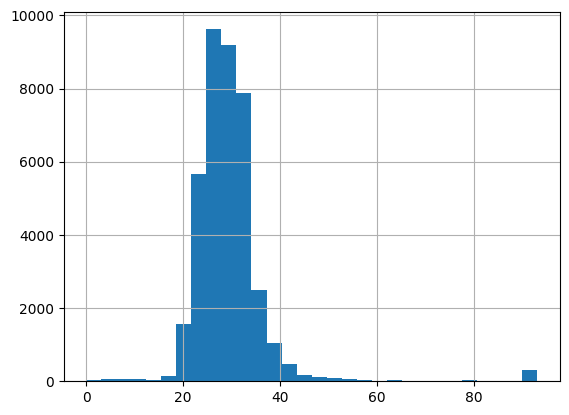

In [63]:
birthday_is_date = pd.api.types.is_datetime64_any_dtype(profiles["birthday"])
today = pd.to_datetime('today')

if not birthday_is_date:
    profiles["birthday"] = profiles["birthday"].map(dict_transform)
    profiles["birthday"] = pd.to_datetime(profiles["birthday"])

profiles["user_age"] = today.year - profiles["birthday"].dt.year
profiles["user_age"].hist(bins=30)

# Obtendo lista de animes favoritos

Os animes favoritos estão relacionados como "['anime1', 'anime2', ...]", vamos ter que obter estas informações como listas do python para relacionar gênero e idade aos an